In [2]:
import os
import sys
import inspect
# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [3]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import get_file_content, get_result_table
from joblib import dump, load
from collections import namedtuple

In [4]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = ["classical", "country", "rock", "pop", "hiphop", "jazz", "blues", "disco", "metal", "reggae"]

In [13]:
experiment_id = 116
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [14]:
pprint(experiment_config)

{'ID': 116,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [],
          'type': '2d'},
 'extra_info': 'main',
 'model': {'classical': {'cnn': {'ignore': True, 'param_grid': {}},
                         'logistic_regression': {'ignore': False,
                                                 'param_grid': {'C': [0.001,
                                                                      0.01,
                                                                      0.1,
                                                                      1.0,
                                                                      10.0,
                                                                      100.0,
                                                                      1000.0],
                                                

In [15]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [16]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)

In [17]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
        )
    ]
print(len(result_list))

16


In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "target_pair_str":[],
        "mean_test_score":[],
        "std_test_score":[],
        "params":[],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name
    
    tmp_result["target_pair_str"] = None
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [19]:
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,additional_structure,target_pair_str,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,classical-svm-ovo-normal-minmax-max_features=8...,classical,svm,ovo,normal,minmax,max_features=8_n_estimators=50,tree,"feature_range=[-1, 1]",None,None,None,0.611429,0.030170,"{'estimator__C': 10, 'estimator__kernel': 'rbf'}",0.573333,"[0.6388888888888888, 0.8095238095238095, 0.461...","[0.6571428571428571, 0.85, 0.32432432432432434...","[0.647887323943662, 0.8292682926829269, 0.3809...",None
1,classical-svm-ovo-normal-minmax-n_components=8...,classical,svm,ovo,normal,minmax,n_components=8,pca,"feature_range=[0, 1]",None,None,None,0.627143,0.033320,"{'estimator__C': 1, 'estimator__kernel': 'rbf'}",0.550000,"[0.5, 0.8636363636363636, 0.5652173913043478, ...","[0.4857142857142857, 0.95, 0.35135135135135137...","[0.49275362318840576, 0.9047619047619048, 0.43...",None
2,classical-logistic_regression-ovo-normal-minma...,classical,logistic_regression,ovo,normal,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]",None,None,None,0.591429,0.030102,"{'estimator__C': 100.0, 'estimator__penalty': ...",0.520000,"[0.37254901960784315, 0.8636363636363636, 0.30...","[0.5428571428571428, 0.95, 0.10810810810810811...","[0.4418604651162791, 0.9047619047619048, 0.16,...",None
3,classical-svm-ovo-normal-minmax-n_components=8...,classical,svm,ovo,normal,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]",None,None,None,0.627143,0.033320,"{'estimator__C': 1, 'estimator__kernel': 'rbf'}",0.550000,"[0.5, 0.8636363636363636, 0.5652173913043478, ...","[0.4857142857142857, 0.95, 0.35135135135135137...","[0.49275362318840576, 0.9047619047619048, 0.43...",None
4,classical-svm-ovo-normal-standard-max_features...,classical,svm,ovo,normal,standard,max_features=8_n_estimators=50,tree,,None,None,None,0.597143,0.039538,"{'estimator__C': 10, 'estimator__kernel': 'rbf'}",0.606667,"[0.7428571428571429, 0.8421052631578947, 0.516...","[0.7428571428571429, 0.8, 0.43243243243243246,...","[0.7428571428571429, 0.8205128205128205, 0.470...",None


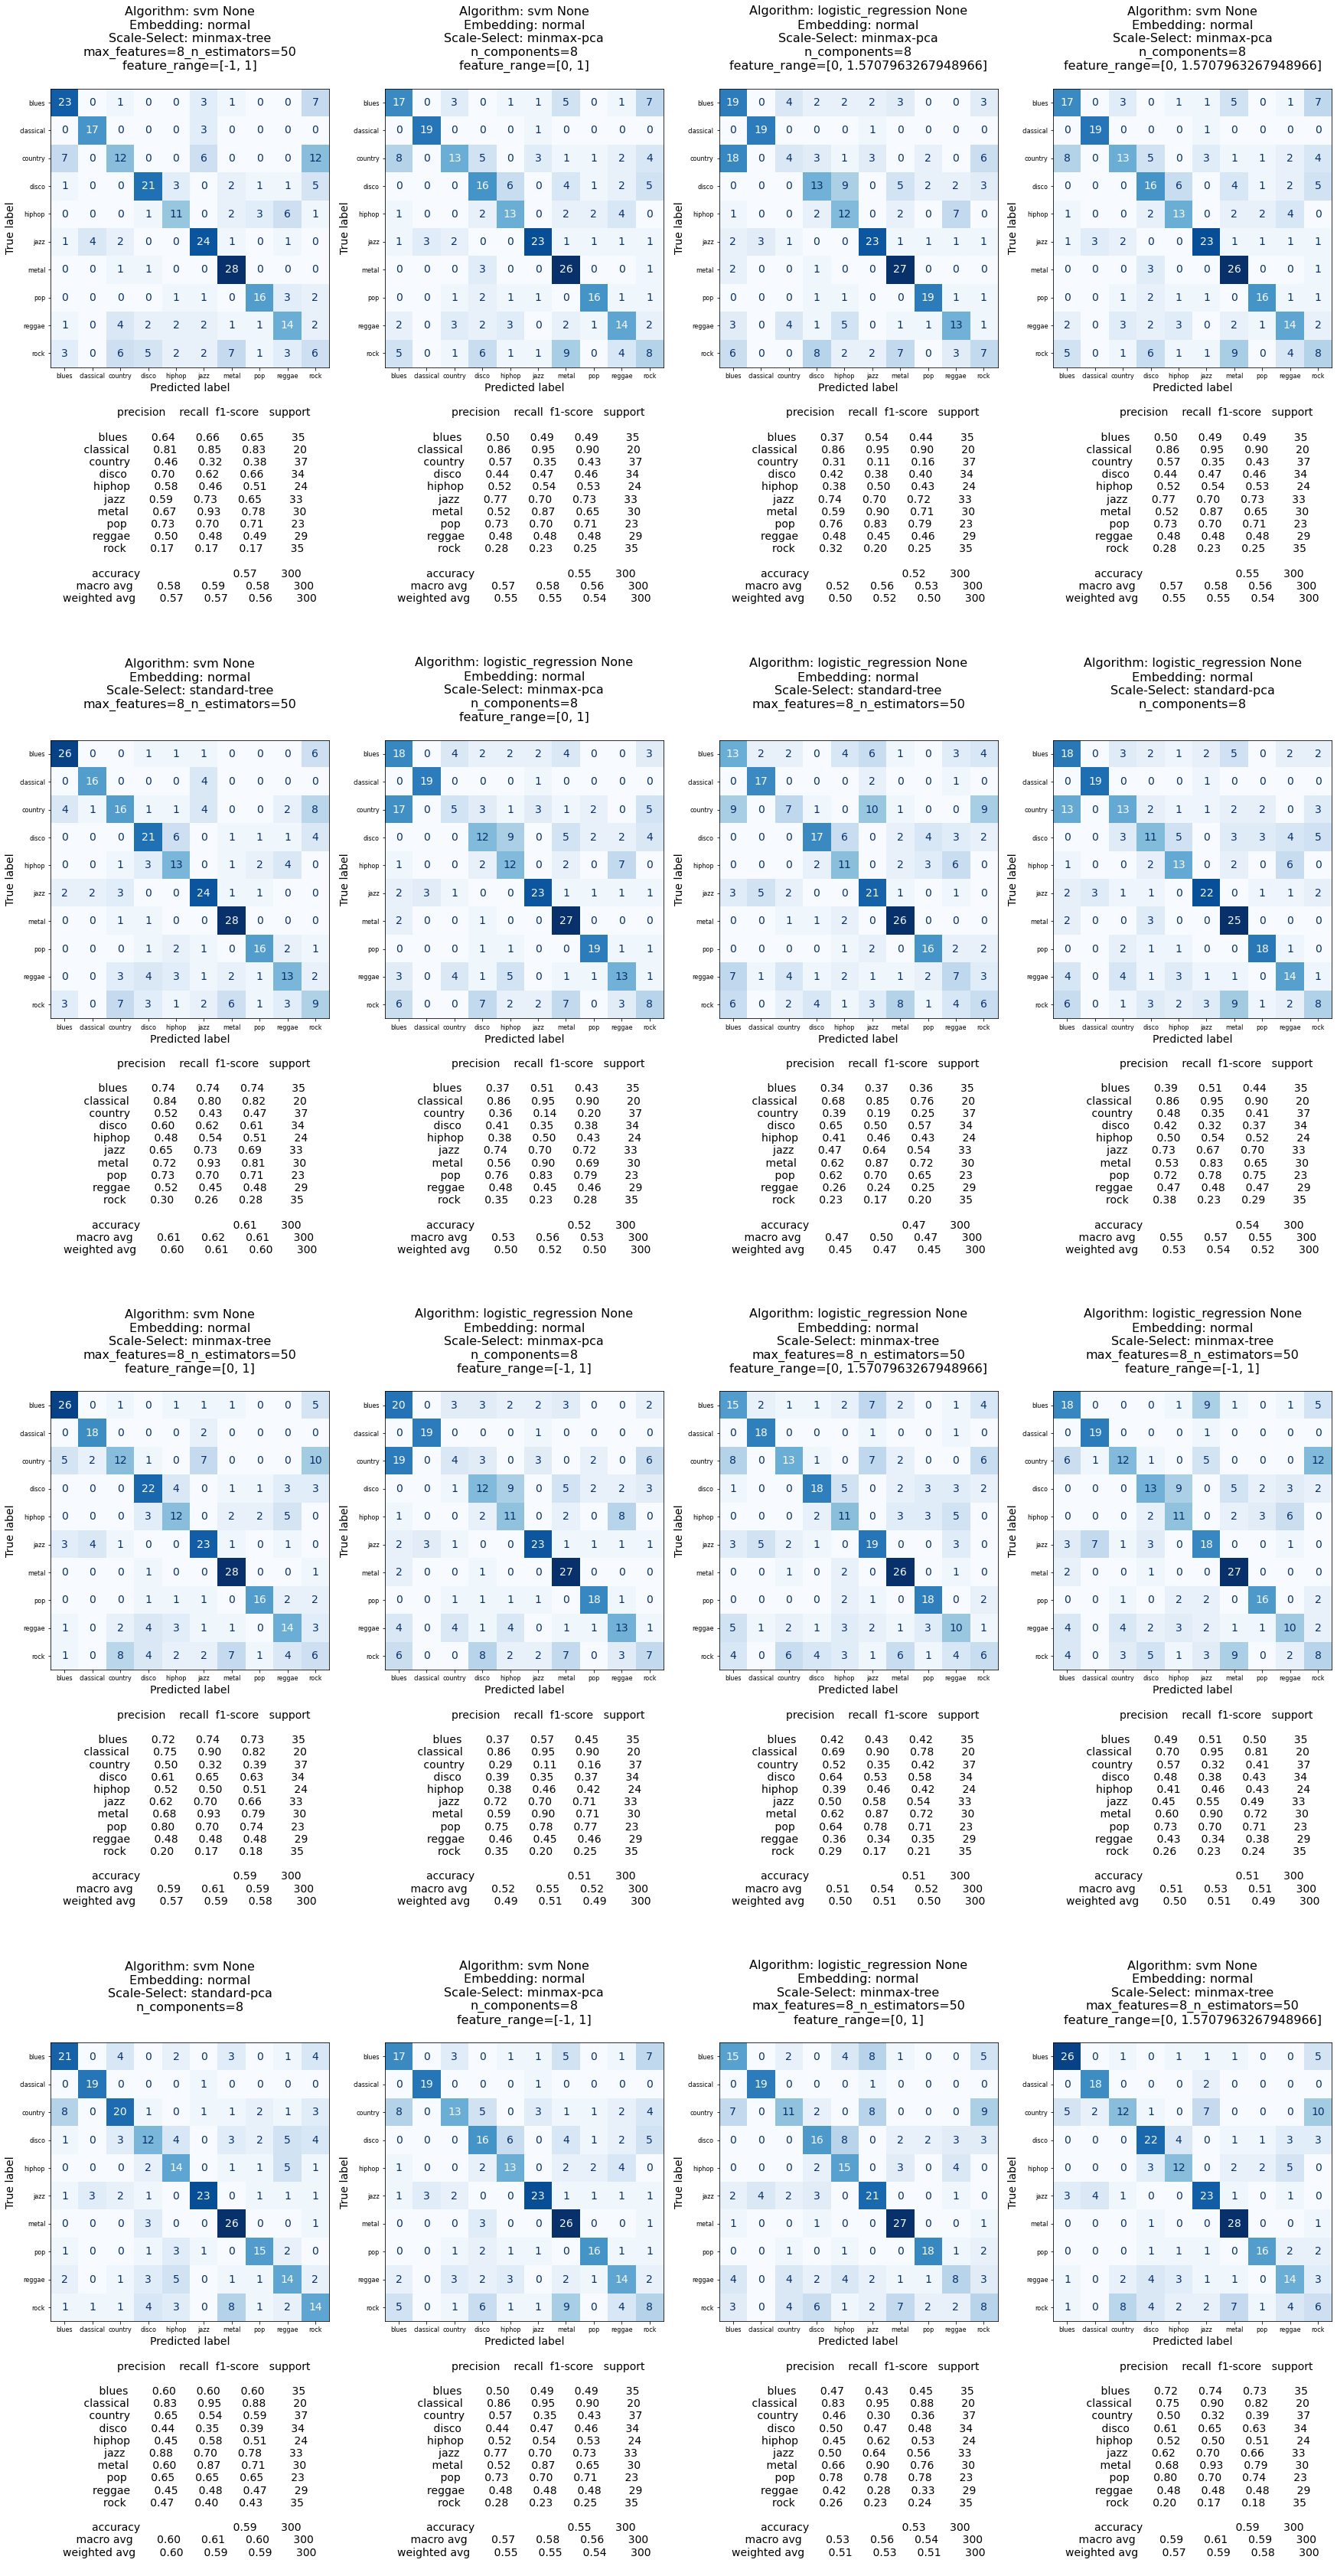

In [26]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 15
columns_in_row = 4
n_plots = len(result_list)
n_rows = int(np.ceil(n_plots / columns_in_row))
fig, axes = plt.subplots(n_rows, columns_in_row, figsize=(row_width, n_rows * row_height))
for result, i in zip(result_list, range(n_plots)):
    col = i % columns_in_row
    row = int(np.floor(i / columns_in_row))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.scaler_param_str}\n{model_configuration.selection_param_str}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
#plt.tight_layout()
fig

In [21]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "accuracy")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.513333,0.550000,0.531667
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.520000,0.550000,0.535000
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.520000,0.550000,0.535000
"(pca, standard, , n_components=8)",0.536667,0.593333,0.565000
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.506667,0.573333,0.540000
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.513333,0.590000,0.551667
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.526667,0.590000,0.558333
"(tree, standard, , max_features=8_n_estimators=50)",0.470000,0.606667,0.538333
scaler_method Average,0.513333,0.575417,0.544375


In [22]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "mean_test_score")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.591429,0.627143,0.609286
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.591429,0.627143,0.609286
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.591429,0.627143,0.609286
"(pca, standard, , n_components=8)",0.610000,0.635714,0.622857
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.565714,0.611429,0.588571
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.565714,0.604286,0.585000
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.582857,0.604286,0.593571
"(tree, standard, , max_features=8_n_estimators=50)",0.567143,0.597143,0.582143
scaler_method Average,0.583214,0.616786,0.600000


In [23]:
get_result_table(result_data, ["selection_method", "scaler_method", "selection_param_str", "scaler_param_str", "algorithm"], "std_test_score")

algorithm,logistic_regression,svm,selection_method Average
"(pca, minmax, feature_range=[-1, 1], n_components=8)",0.027627,0.033320,0.030473
"(pca, minmax, feature_range=[0, 1.5707963267948966], n_components=8)",0.030102,0.033320,0.031711
"(pca, minmax, feature_range=[0, 1], n_components=8)",0.024908,0.033320,0.029114
"(pca, standard, , n_components=8)",0.064143,0.045175,0.054659
"(tree, minmax, feature_range=[-1, 1], max_features=8_n_estimators=50)",0.043659,0.030170,0.036914
"(tree, minmax, feature_range=[0, 1.5707963267948966], max_features=8_n_estimators=50)",0.041502,0.020996,0.031249
"(tree, minmax, feature_range=[0, 1], max_features=8_n_estimators=50)",0.028067,0.020996,0.024531
"(tree, standard, , max_features=8_n_estimators=50)",0.032764,0.039538,0.036151
scaler_method Average,0.036597,0.032104,0.034350
